In [1]:
## Import Essential Data handling libraries
import pandas as pd
import numpy as np

from math import floor
from time import perf_counter

import matplotlib.pyplot as plt,seaborn as sns
import matplotlib as mpl
%matplotlib inline


from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
### Importing Machine Learning Libraries and functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier

import lightgbm as lgb

#### Loading Data

In [4]:
df_raw = pd.read_csv("..\data\creditcard.csv")

In [5]:
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [6]:
df_raw.drop(["Time"], axis = 1, inplace  = True)

In [7]:
df = df_raw.copy()

##### Checking Class Distribution

In [136]:
print(df_raw.Class.value_counts())

print("\n","% distribution\n",df_raw.Class.value_counts(True)*100)

0    284315
1       492
Name: Class, dtype: int64

 % distribution
 0   99.827
1    0.173
Name: Class, dtype: float64


In [8]:
df.shape

(284807, 30)

### 1. Correlation Check

#### Vizualizing the correlation of variables among themselves

In [9]:
correlations = df.iloc[:,:-1].corr(method='pearson')

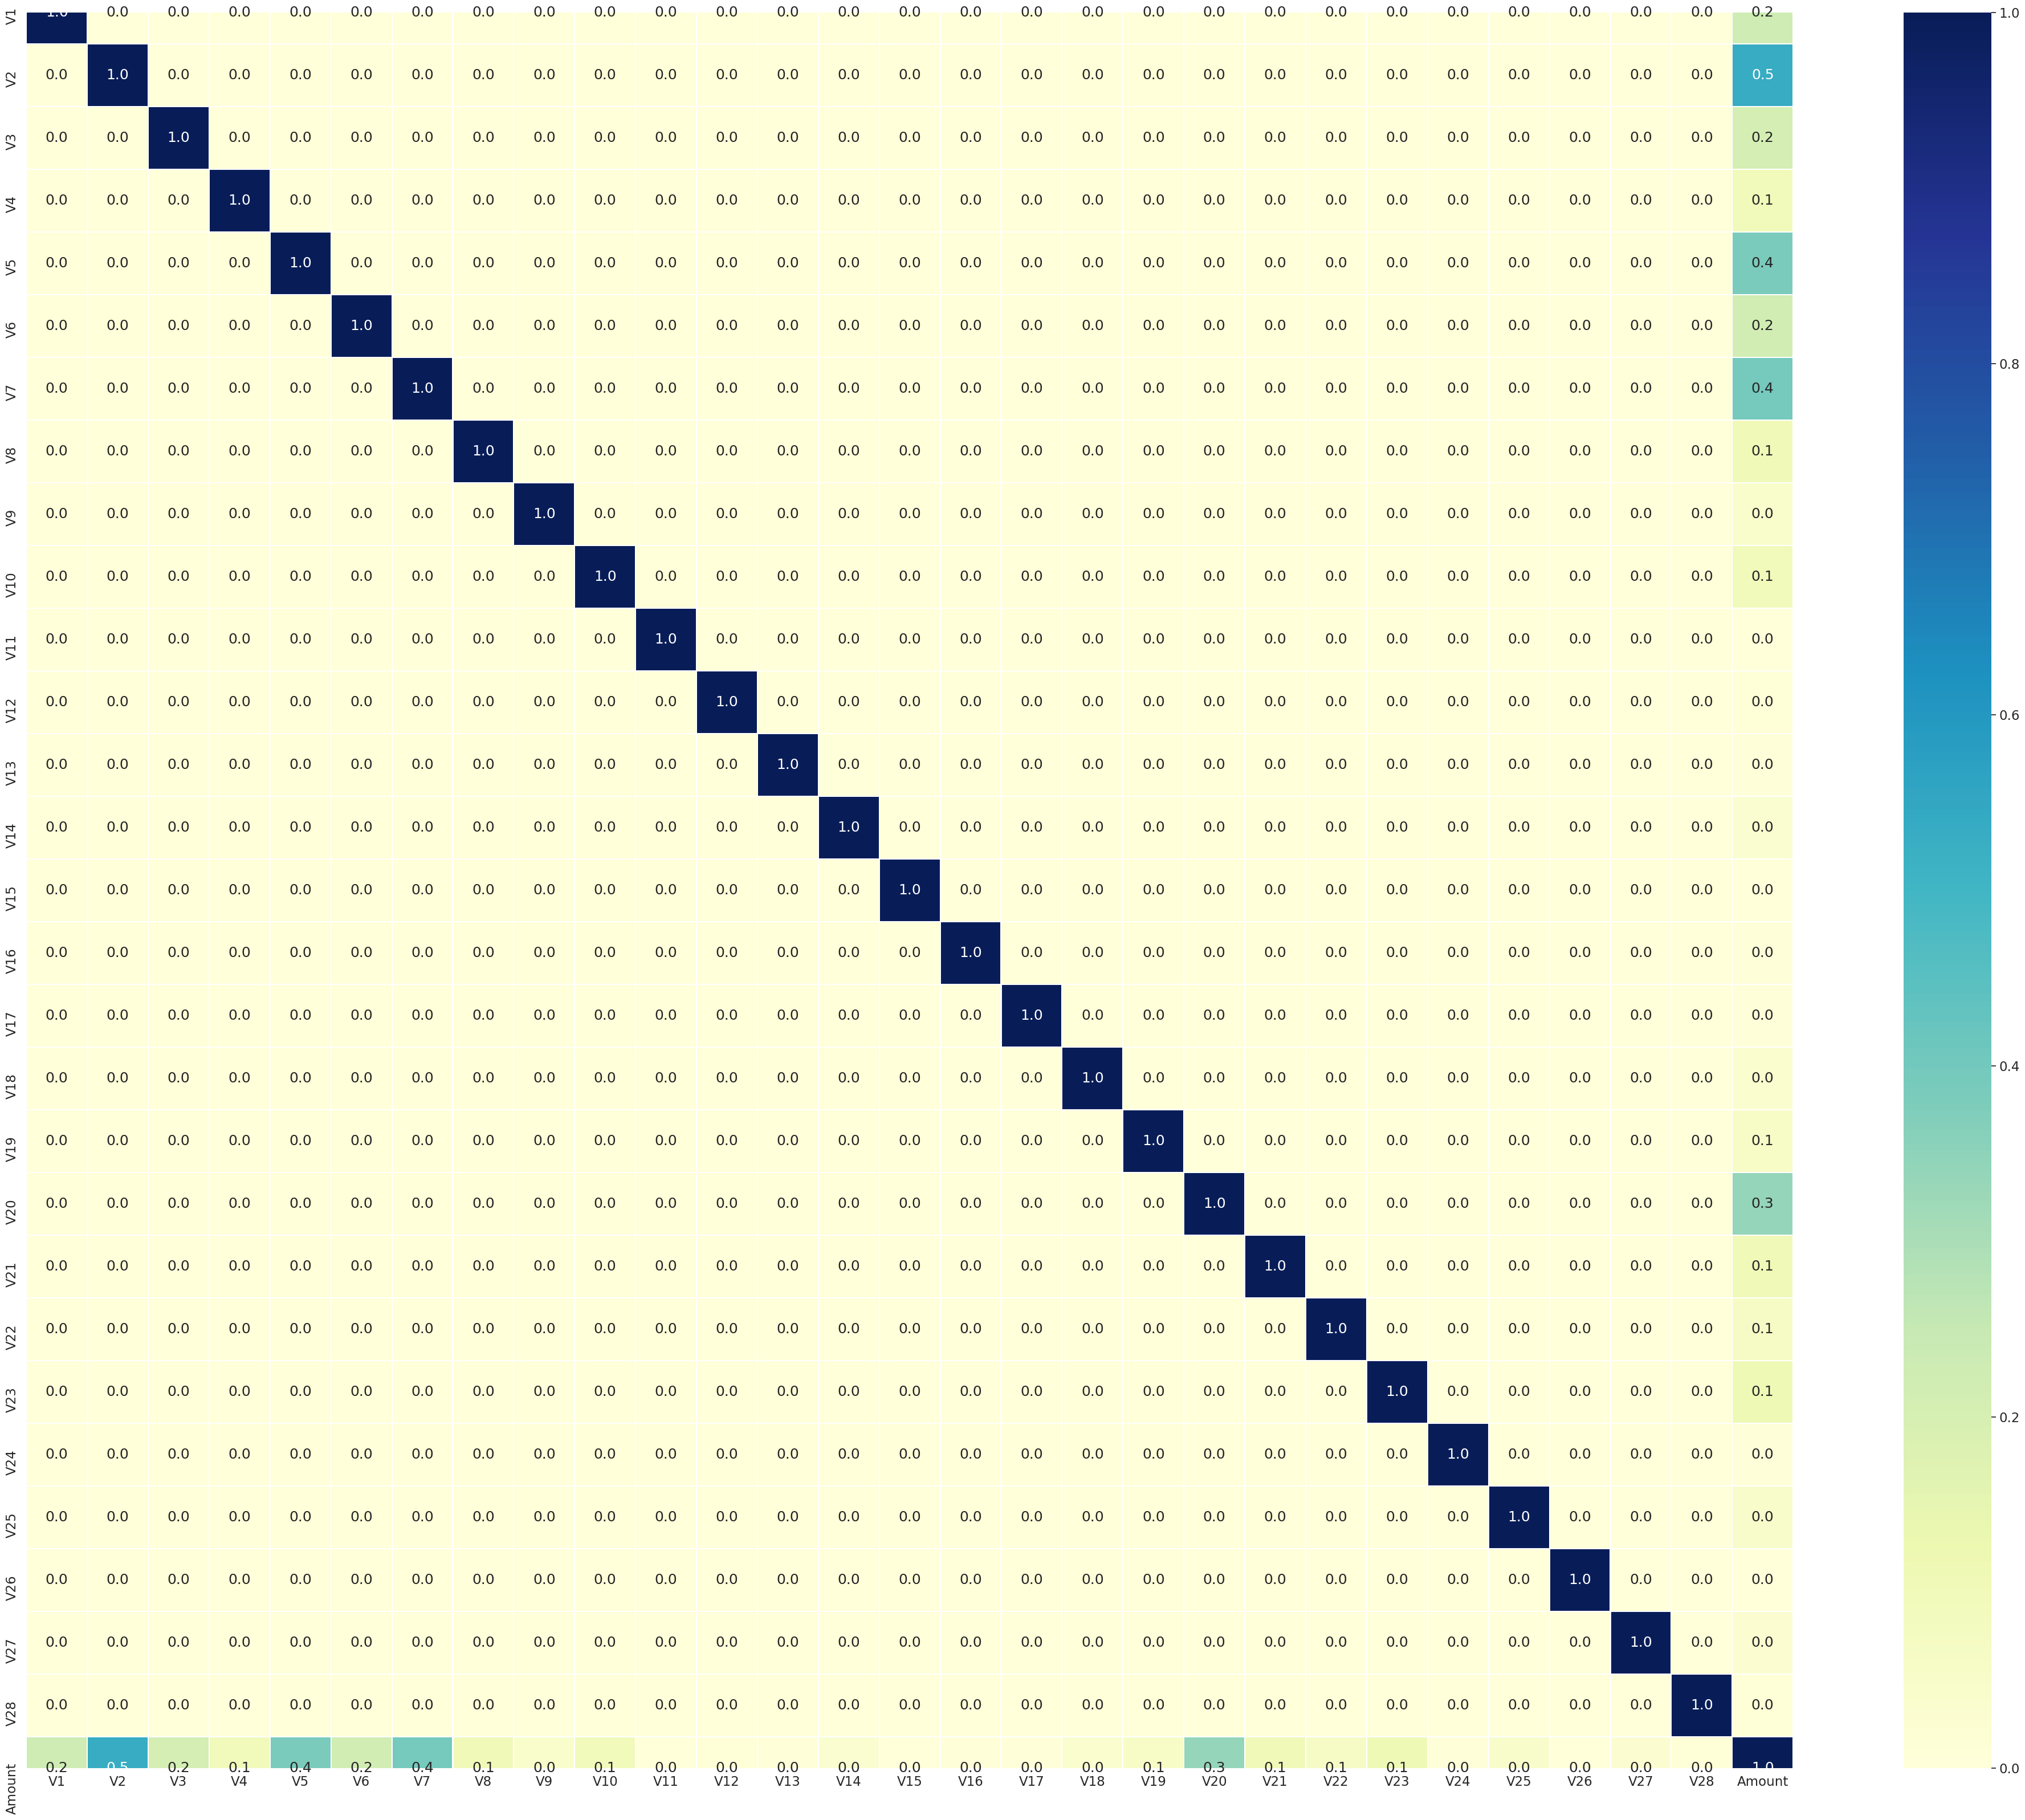

In [140]:
#correlation map
sns.set(font_scale=1.5)
f,ax = plt.subplots(figsize=(50,40))
sns.heatmap(np.abs(correlations), annot=True, linewidths= .8, fmt= ".1f",ax=ax, cmap="YlGnBu")
mpl.rcParams.update(mpl.rcParamsDefault)

##### Only amount has some correlation (not significant ) with other predictors, rest features are independent of each other

### 2.  Univariate Statistics and Plots

In [11]:
plt.rcParams["figure.figsize"] = [19, 21]

In [12]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


#### 1. Histogram

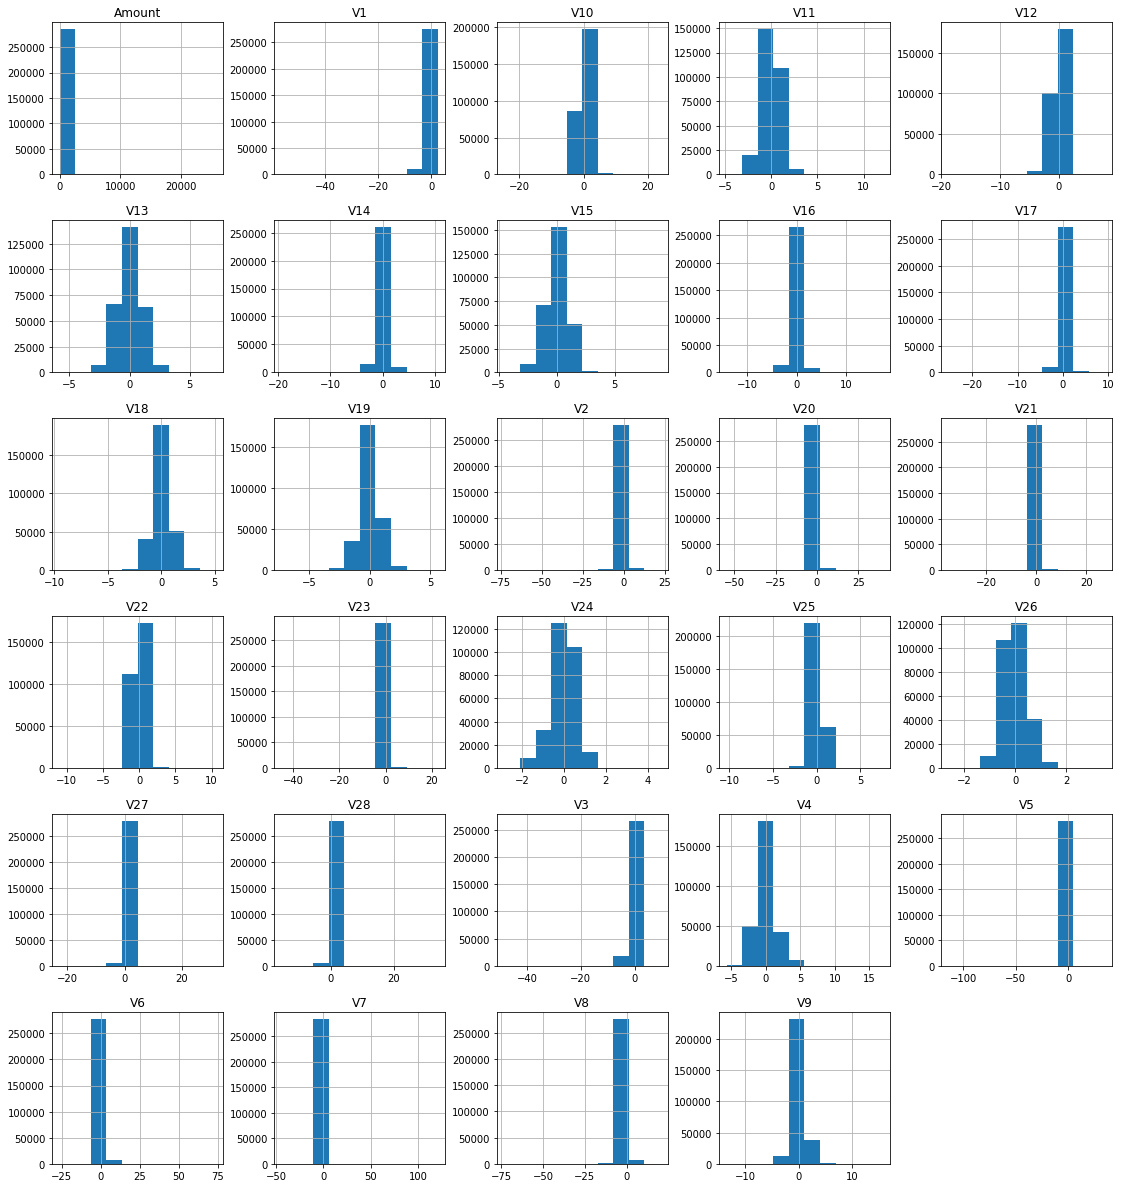

In [13]:
plt.rcParams["figure.figsize"] = [19, 21]
df.iloc[:,:-1].hist()
plt.show()

#### 2. Density Plots

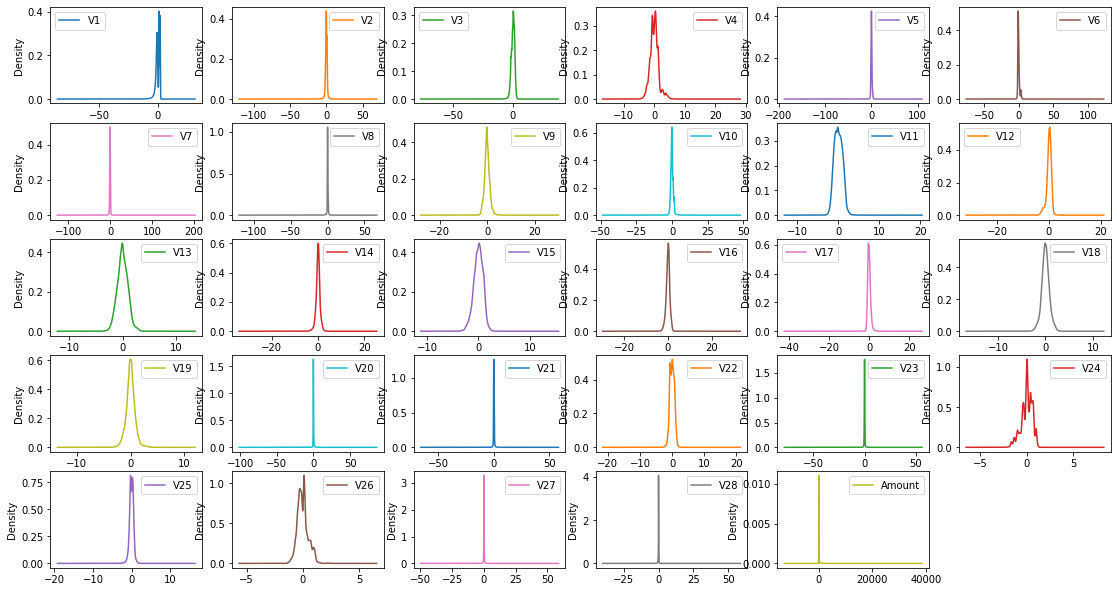

In [15]:
df.iloc[:,:-1].plot(kind='density', subplots=True, layout=(10,6), sharex=False)
plt.show()

#### 3. BoxPlots

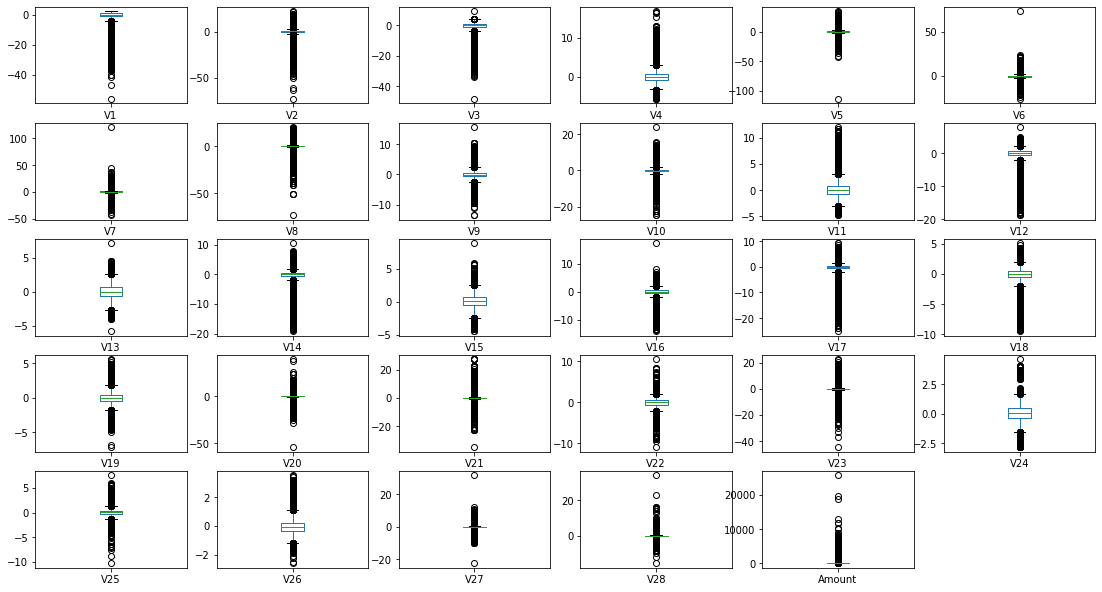

In [18]:
df.iloc[:,:-1].plot(kind='box', subplots=True, layout=(10,6), sharex=False)
plt.show()

##### Lots and lots of outliers. .. .  (have to deal with them, transformations or outliers removal)

### 3. Bivariate Plots and analysis

#### 1. Bivariate density plots

In [ ]:
##### axs setting : 
##### First Index = floor(i/ncols)
##### Second Index = Remainder(i/ncols)

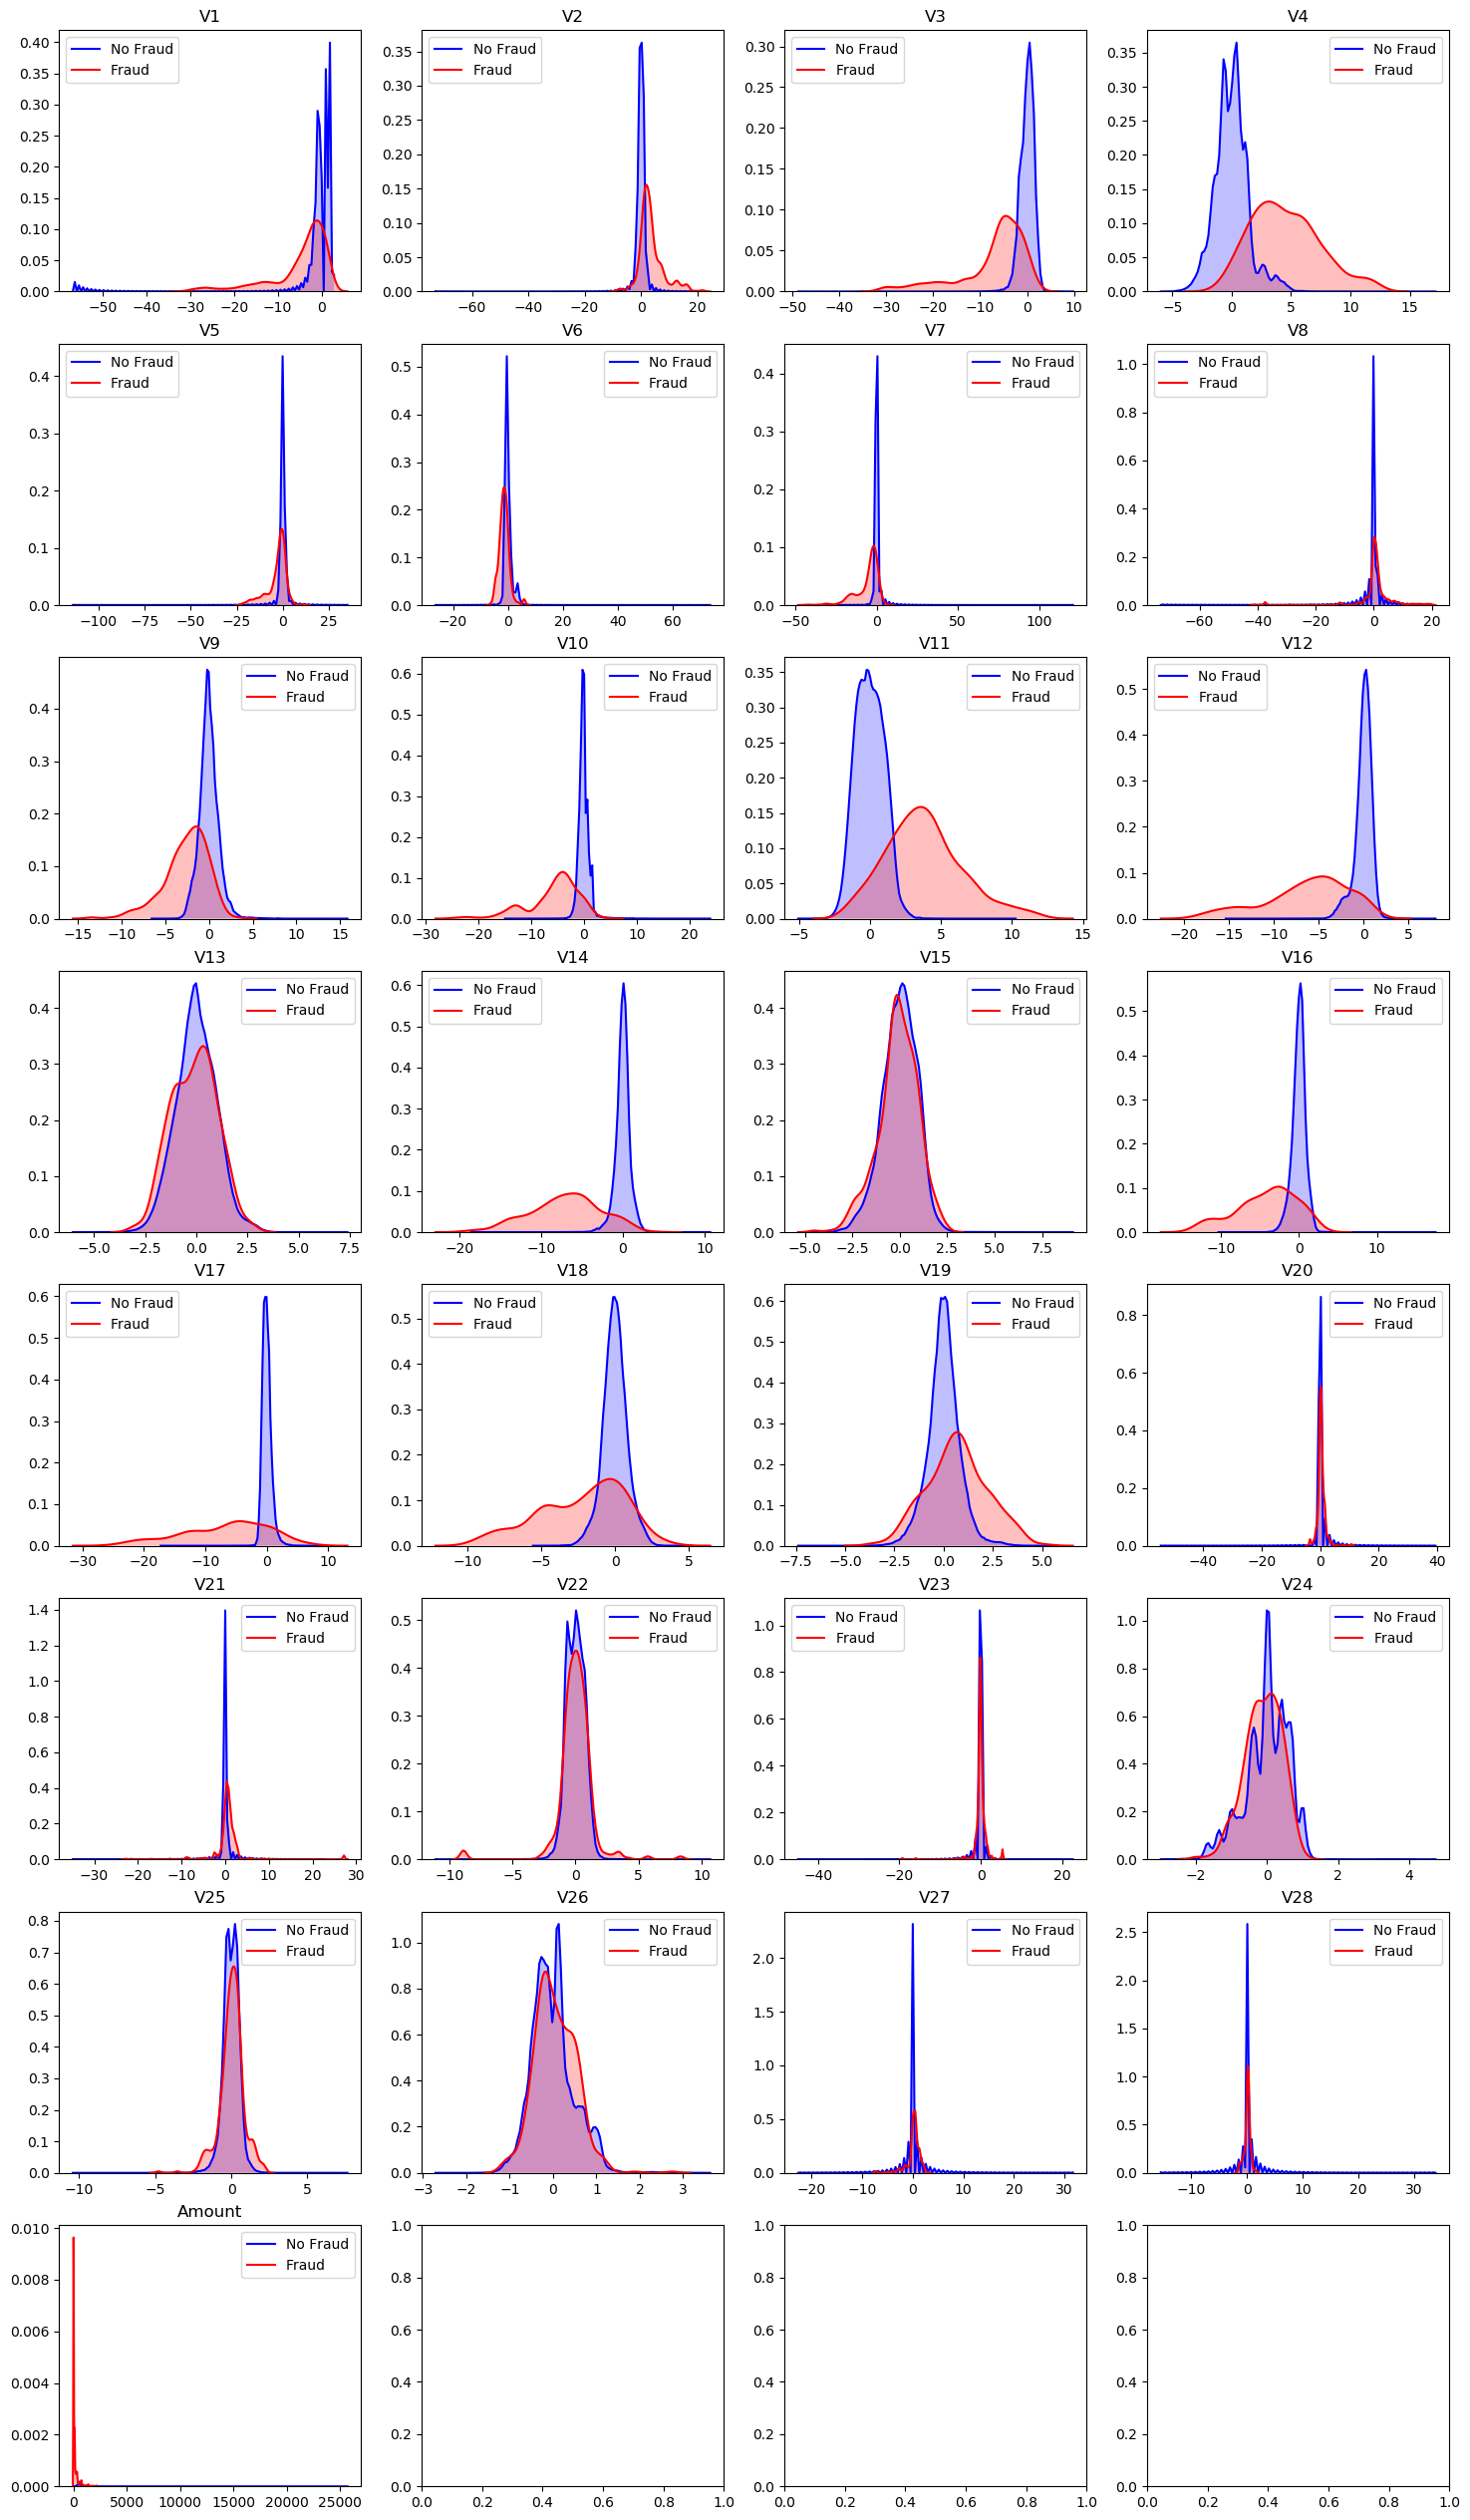

In [97]:
ncols = 4
nrows = 8

plt.rcParams["figure.figsize"] = [18, 32]
fig, axs = plt.subplots(ncols = ncols, nrows = nrows)

for i,var in enumerate(list(df.columns)[:-1]):
    axs[floor(i/ncols), i%ncols].set_title(var)
    sns.kdeplot(df.loc[df["Class"]==0,var], shade=True, color="b", label = "No Fraud" , ax = axs[floor(i/ncols), i%ncols])
    sns.kdeplot(df.loc[df["Class"]==1,var], shade=True, color="r",  label = "Fraud" , ax = axs[floor(i/ncols), i%ncols])

mpl.rcParams.update(mpl.rcParamsDefault)

#### 2. Bivariate density plots after 
* 1. Quantile Transformation (normal distribution)
* 2. standard scaling the data

In [8]:
quantile_transformer = QuantileTransformer(output_distribution="normal")
standard_scaler = StandardScaler()

In [9]:
df_transformed = df_raw.copy()

for i in range(df_transformed.iloc[:,:-1].shape[1]):
    qt_transformed_var = quantile_transformer.fit_transform(df_transformed.iloc[:,i].values.reshape(-1,1))[:,0]
    qt_transformed_std_scaled = standard_scaler.fit_transform(qt_transformed_var.reshape(-1,1))[:,0]
    
    df_transformed.iloc[:,i] = qt_transformed_std_scaled


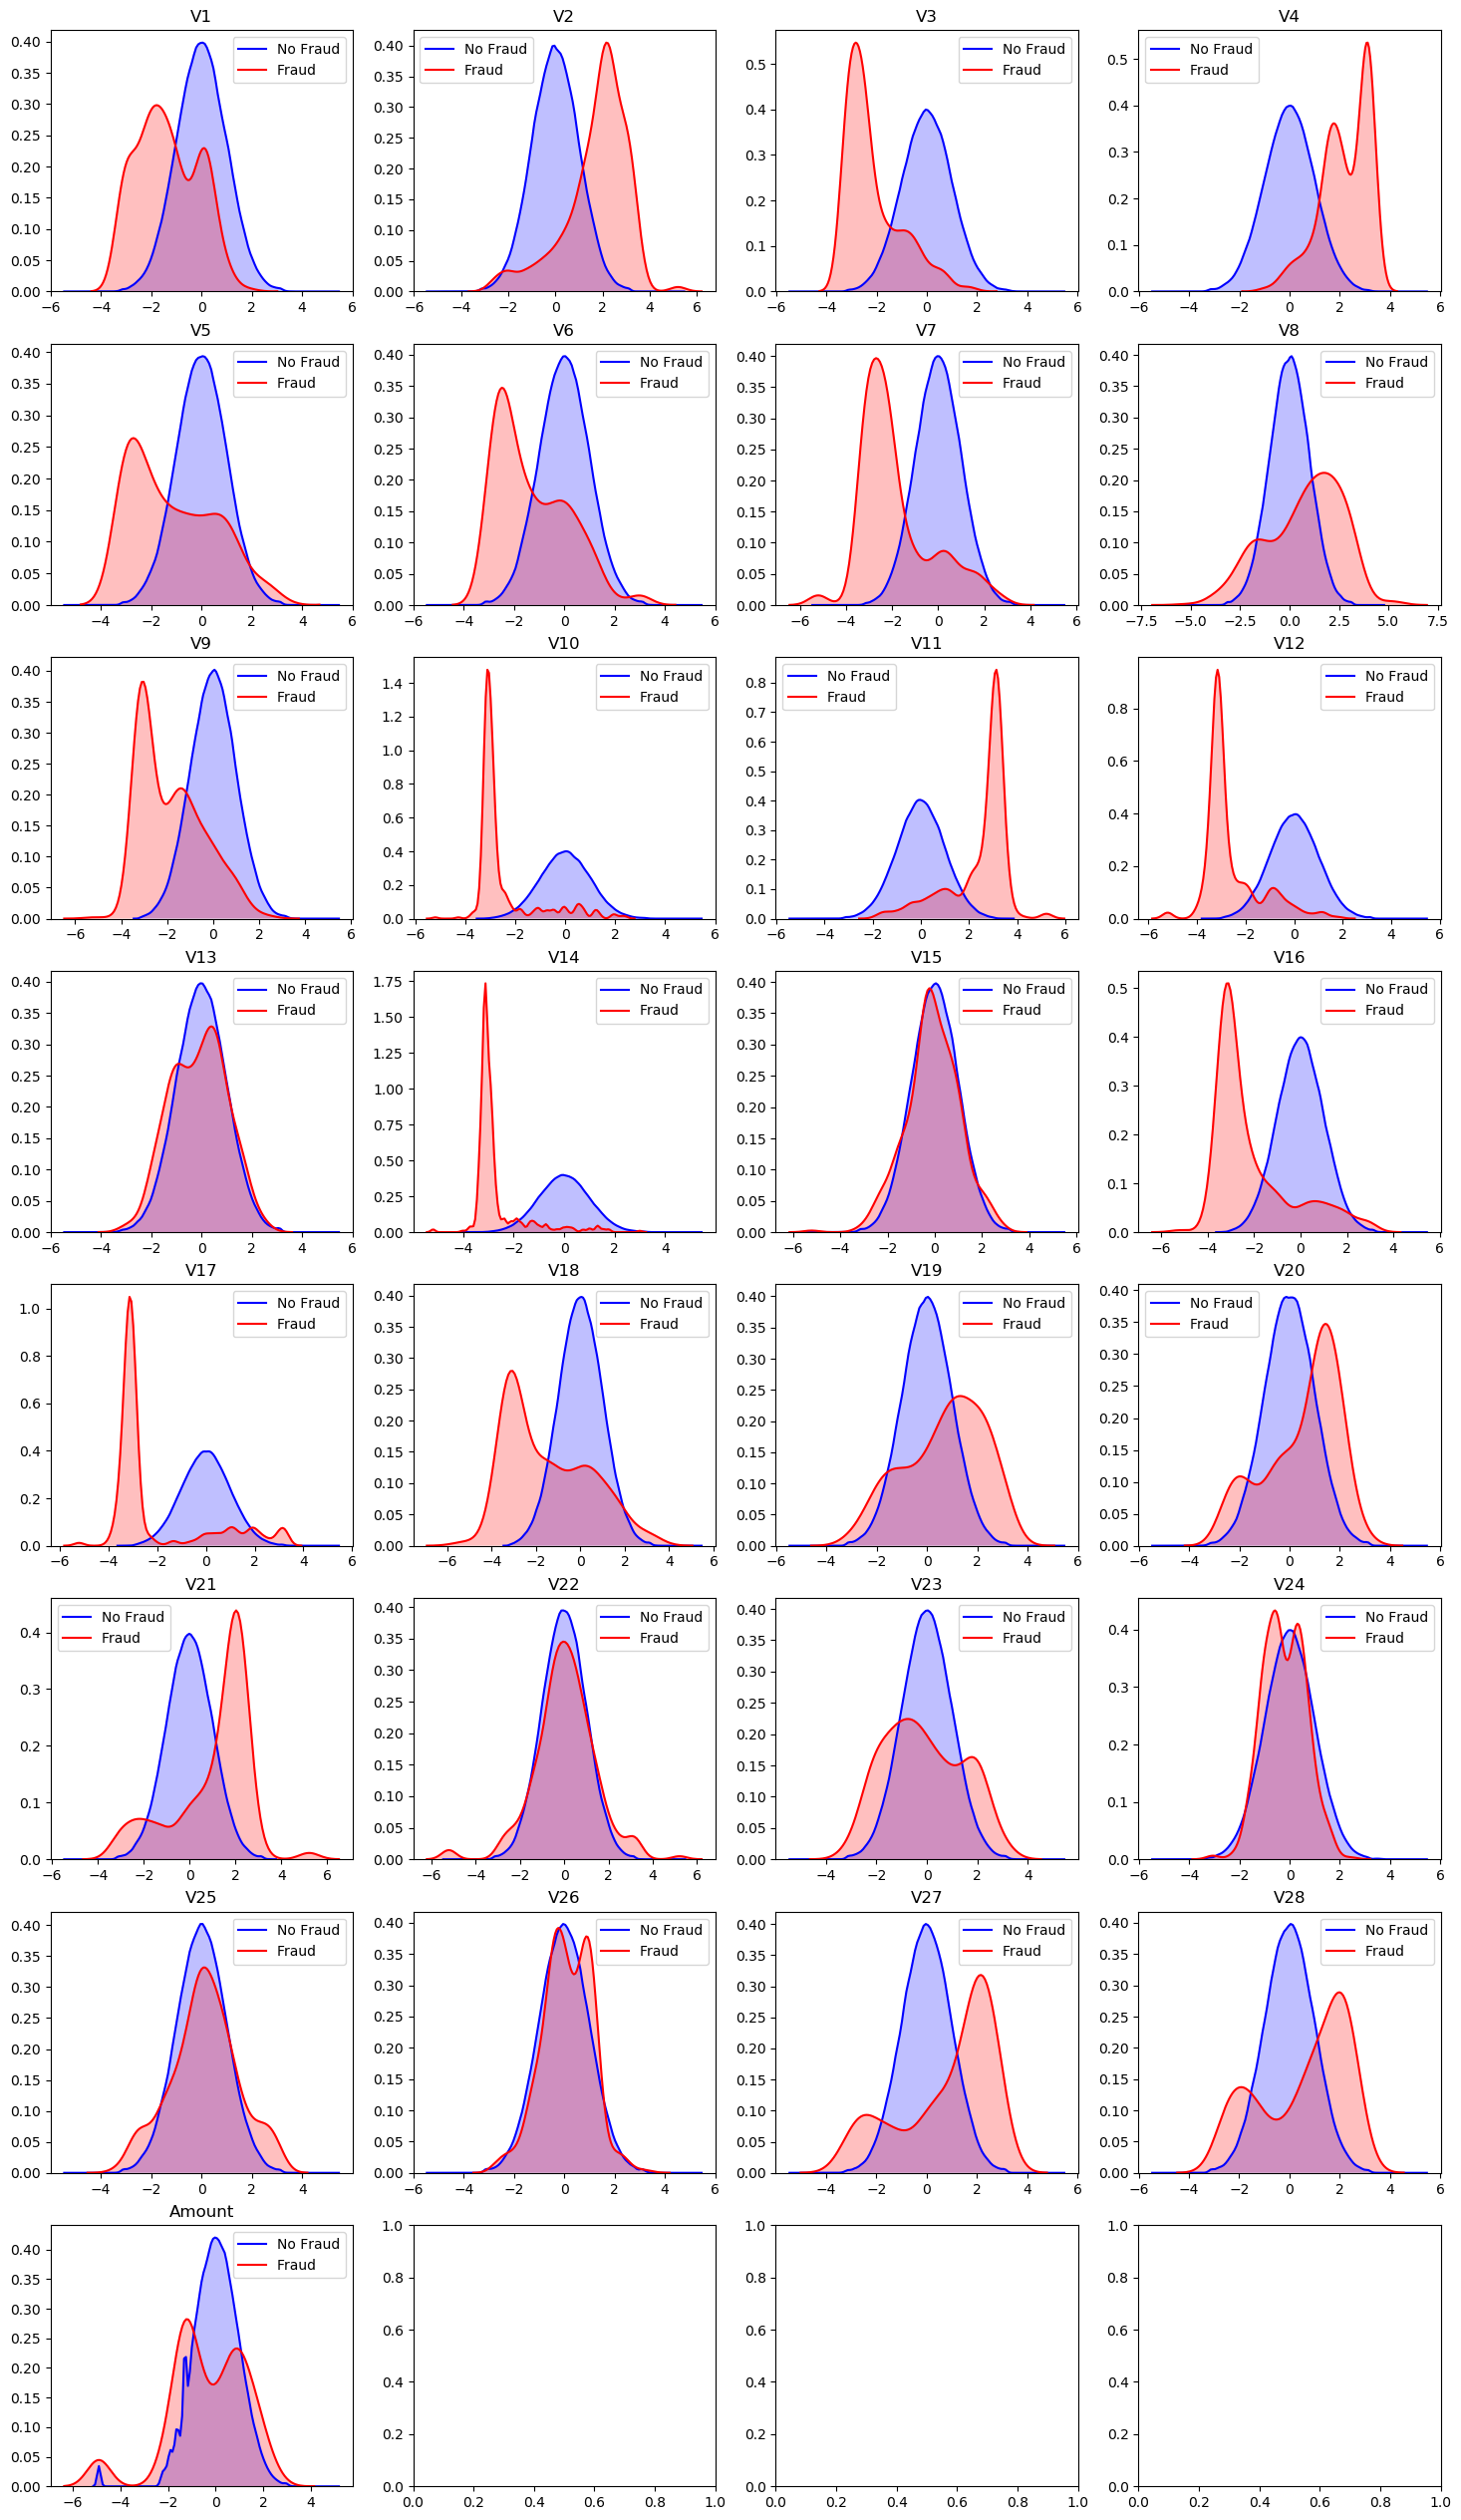

In [131]:
ncols = 4
nrows = 8

plt.rcParams["figure.figsize"] = [18, 32]
fig, axs = plt.subplots(ncols = ncols, nrows = nrows)

for i,var in enumerate(list(df_transformed.columns)[:-1]):
    axs[floor(i/ncols), i%ncols].set_title(var)
    sns.kdeplot(df_transformed.loc[df_transformed["Class"]==0,var], shade=True, 
                color="b", label = "No Fraud" , ax = axs[floor(i/ncols), i%ncols])
    sns.kdeplot(df_transformed.loc[df_transformed["Class"]==1,var], shade=True, 
                color="r",  label = "Fraud" , ax = axs[floor(i/ncols), i%ncols])

mpl.rcParams.update(mpl.rcParamsDefault)

### Evaluate Algorithms: Baseline

In [10]:
# Test options and evaluation metric
num_folds = 5
seed = 7
scoring = 'f1'

In [11]:
# models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('NB', GaussianNB()))

# models.append(('RF', RandomForestClassifier()))
# models.append(('ETC', ExtraTreesClassifier()))
# models.append(('LGBM', lgb.LGBMClassifier()))
# models.append(('XGB', XGBClassifier()))


# defining models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))

models.append(('RF', RandomForestClassifier()))

models.append(('ETC', ExtraTreesClassifier()))

models.append(('LGBM', lgb.LGBMClassifier()))

models.append(('XGB', XGBClassifier()))



# models.append(('ADA', AdaBoostClassifier()))
# models.append(('KNN', KNeighborsClassifier(n_neighbors = 11)))

#### 1. Using Raw features (without transformation)

In [ ]:
results = []
names = []
time_taken = {}
for name, model in models:
    t0 = perf_counter()
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, df.iloc[:,:-1].values, df.iloc[:,-1].values, 
                                 cv = kfold, scoring = scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
    t1 = perf_counter()
    time_taken[name] = (t1 - t0)/60
    msg = "%s: %f (%f)" % (name, np.mean(cv_results), cv_results.std())
    print(msg)
    print("Time Taken (minutes) : ", np.round(time_taken[name],2),"\n")

LR: 0.674652 (0.091029)
Time Taken (minutes) :  1.65 

LDA: 0.759892 (0.073172)
Time Taken (minutes) :  0.36 

NB: 0.112538 (0.040499)
Time Taken (minutes) :  0.07 



In [ ]:
# comapre algorithms (box plots)
results_df = pd.DataFrame(np.array(results).T,columns=names)
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df)
sns.swarmplot(data=results_df,color = "black")
plt.title("F1 Score comparision, 5 fold CV : Raw Data")

#### 2. Using transformed features (normal tranformation and std. scaled)

In [12]:
results = []
names = []
time_taken = {}
for name, model in models:
    t0 = perf_counter()
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, df_transformed.iloc[:,:-1].values, df_transformed.iloc[:,-1].values, 
                                 cv = kfold, scoring = scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
    t1 = perf_counter()
    time_taken[name] = (t1 - t0)/60
    msg = "%s: %f (%f)" % (name, np.mean(cv_results), cv_results.std())
    print(msg)
    print("Time Taken (minutes) : ", time_taken[name], "\n")

LR: 0.810256 (0.028667)
Time Taken (minutes) :  0.8298638716666669 

LDA: 0.808865 (0.012732)
Time Taken (minutes) :  0.39567631833333317 

NB: 0.502578 (0.092235)
Time Taken (minutes) :  0.04859115500000068 

RF: 0.787768 (0.024677)
Time Taken (minutes) :  2.343555605 

ETC: 0.780759 (0.027137)
Time Taken (minutes) :  0.29898747333333325 

LGBM: 0.183821 (0.121814)
Time Taken (minutes) :  0.3599884366666667 

XGB: 0.820251 (0.014237)
Time Taken (minutes) :  9.377873036666669 



Text(0.5, 1.0, 'F1 Score comparision, 5 fold CV : Transformed Data')

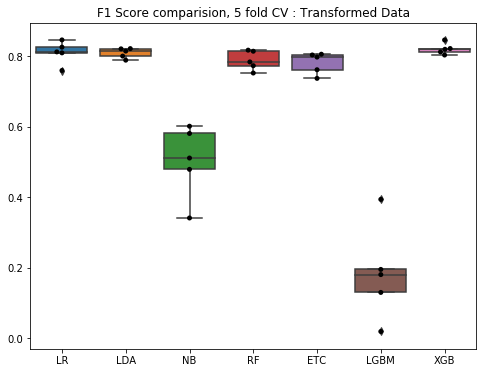

In [13]:
# comapre algorithms (box plots)
results_df = pd.DataFrame(np.array(results).T,columns=names)
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df)
sns.swarmplot(data=results_df,color = "black")
plt.title("F1 Score comparision, 5 fold CV : Transformed Data")

In [ ]:
results_df